In [177]:
!pip install requests beautifulsoup4 nltk textblob wordcloud scikit-learn imbalanced-learn pandas matplotlib seaborn


In [178]:
import requests
from bs4 import BeautifulSoup
import re
import nltk
import pandas as pd
from textblob import TextBlob
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
import joblib

nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [179]:
url = "https://en.wikipedia.org/wiki/Nigeria"
response = requests.get(url)
soup = BeautifulSoup(response.text, "html.parser")
text = soup.get_text()

In [180]:
text = re.sub(r'\n+', ' ', text)
text = re.sub(r'\[\d+\]', '', text)
text = re.sub(r'[^a-zA-Z. ]', '', text)
text = re.sub(r'\s+', ' ', text).strip()

In [181]:
sentences = sent_tokenize(text)

In [182]:
def analyze_sentiment(sentence):
    return TextBlob(sentence).sentiment.polarity
df = pd.DataFrame(sentences, columns=["sentence"])
df["sentiment_score"] = df["sentence"].apply(analyze_sentiment)
df["sentiment"] = df["sentiment_score"].apply(lambda x: "positive" if x > 0 else ("negative" if x < 0 else "neutral"))


In [183]:
words = word_tokenize(text.lower())
stop_words = set(stopwords.words('english'))
filtered_words = [word for word in words if word.isalpha() and word not in stop_words]


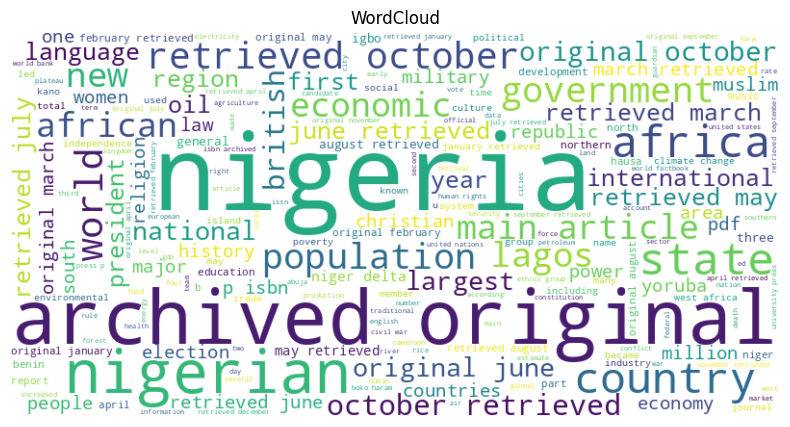

In [184]:
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(filtered_words))
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('WordCloud')
plt.show()

In [185]:
from collections import Counter
word_freq = Counter(filtered_words)
print("Top 10 frequent words:", word_freq.most_common(10))

Top 10 frequent words: [('nigeria', 481), ('retrieved', 265), ('archived', 257), ('original', 248), ('nigerian', 141), ('october', 110), ('june', 94), ('may', 94), ('africa', 80), ('march', 76)]


In [186]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(df["sentence"])
y = df["sentiment"]

In [187]:
df_binary = df[df["sentiment"] != "neutral"]
X_binary = vectorizer.transform(df_binary["sentence"])
y_binary = df_binary["sentiment"].map({"positive": 1, "negative": 0})  # binary 1=positive, 0=negative


In [188]:
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_binary, y_binary)

In [189]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)


In [190]:
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train, y_train)
y_pred_log = log_reg.predict(X_test)

print("🔹 Logistic Regression Report")
print(classification_report(y_test, y_pred_log))


🔹 Logistic Regression Report
              precision    recall  f1-score   support

           0       0.81      0.99      0.89       128
           1       0.99      0.75      0.85       118

    accuracy                           0.87       246
   macro avg       0.90      0.87      0.87       246
weighted avg       0.90      0.87      0.87       246



In [191]:
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)
y_pred_dt = dt.predict(X_test)

print("🔹 Decision Tree Report")
print(classification_report(y_test, y_pred_dt))


🔹 Decision Tree Report
              precision    recall  f1-score   support

           0       0.85      0.88      0.86       128
           1       0.86      0.83      0.84       118

    accuracy                           0.85       246
   macro avg       0.85      0.85      0.85       246
weighted avg       0.85      0.85      0.85       246



In [192]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

print("🔹 Random Forest Report")
print(classification_report(y_test, y_pred_rf))


🔹 Random Forest Report
              precision    recall  f1-score   support

           0       0.90      0.96      0.93       128
           1       0.95      0.89      0.92       118

    accuracy                           0.93       246
   macro avg       0.93      0.93      0.93       246
weighted avg       0.93      0.93      0.93       246



In [193]:
gb = GradientBoostingClassifier()
gb.fit(X_train, y_train)
y_pred_gb = gb.predict(X_test)

print("🔹 Gradient Boosting Report")
print(classification_report(y_test, y_pred_gb))


🔹 Gradient Boosting Report
              precision    recall  f1-score   support

           0       0.85      0.96      0.90       128
           1       0.95      0.82      0.88       118

    accuracy                           0.89       246
   macro avg       0.90      0.89      0.89       246
weighted avg       0.90      0.89      0.89       246



In [194]:
X_train_nb = X_train.copy()
X_train_nb.data = X_train_nb.data.clip(min=0)
X_test_nb = X_test.copy()
X_test_nb.data = X_test_nb.data.clip(min=0)

nb = MultinomialNB()
nb.fit(X_train_nb, y_train)
y_pred_nb = nb.predict(X_test_nb)

print("🔹 Naive Bayes Report")
print(classification_report(y_test, y_pred_nb))


🔹 Naive Bayes Report
              precision    recall  f1-score   support

           0       0.78      0.99      0.88       128
           1       0.99      0.70      0.82       118

    accuracy                           0.85       246
   macro avg       0.89      0.85      0.85       246
weighted avg       0.88      0.85      0.85       246



In [195]:
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
y_pred_knn = knn.predict(X_test)

print("🔹 KNN Report")
print(classification_report(y_test, y_pred_knn))


🔹 KNN Report
              precision    recall  f1-score   support

           0       0.63      1.00      0.77       128
           1       1.00      0.36      0.53       118

    accuracy                           0.70       246
   macro avg       0.82      0.68      0.65       246
weighted avg       0.81      0.70      0.66       246



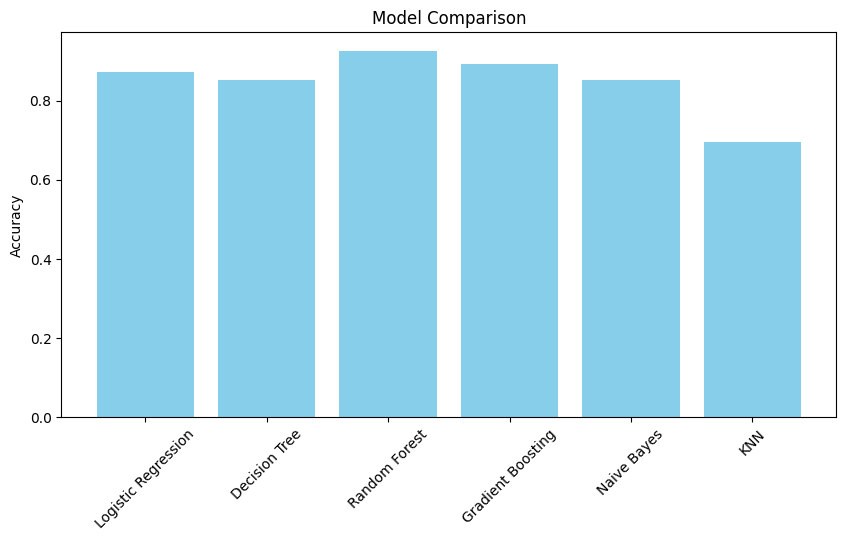

In [196]:
import matplotlib.pyplot as plt

models_accuracy = {
    "Logistic Regression": accuracy_score(y_test, y_pred_log),
    "Decision Tree": accuracy_score(y_test, y_pred_dt),
    "Random Forest": accuracy_score(y_test, y_pred_rf),
    "Gradient Boosting": accuracy_score(y_test, y_pred_gb),
    "Naive Bayes": accuracy_score(y_test, y_pred_nb),
    "KNN": accuracy_score(y_test, y_pred_knn)
}

plt.figure(figsize=(10, 5))
plt.bar(models_accuracy.keys(), models_accuracy.values(), color='skyblue')
plt.xticks(rotation=45)
plt.ylabel("Accuracy")
plt.title("Model Comparison")
plt.show()


In [197]:
final_model = models["Random Forest"]
# Fit model
rf = RandomForestClassifier()
rf.fit(X_train, y_train)

# Save only AFTER fitting
import joblib
joblib.dump(rf, "random_forest_sentiment_model.pkl")  # ✅ trained model
joblib.dump(vectorizer, "tfidf_vectorizer.pkl")

print("\n✅ Random Forest model and vectorizer saved as 'random_forest_sentiment_model.pkl' and 'tfidf_vectorizer.pkl'")



✅ Random Forest model and vectorizer saved as 'random_forest_sentiment_model.pkl' and 'tfidf_vectorizer.pkl'


In [176]:
!pip install -r requirements.txt
!streamlit run app.py





  You can now view your Streamlit app in your browser.

  Local URL: http://localhost:8501
  Network URL: http://172.28.0.12:8501
  External URL: http://34.16.182.154:8501

  Stopping...
  Stopping...
